In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.plot import reshape_as_raster, reshape_as_image
from glob import glob

In [41]:
def make_combined(tile_number, ls8_filepaths, dates):
    j = 0
    for ls8_fp in ls8_filepaths:
        ls8_band_paths = glob(ls8_fp + '*SRB*')
        ls8_band_paths.sort()
        ls8_band_paths += glob(ls8_fp + '*PIXELQA*')
        img_fp = '/deep_data/recurrent_data/' + 'tile' + tile_number + '/' + 'combined/' + 'combined' +dates[j]+'.tif'
        j+=1
        # Read metadata of first file and assume all other bands are the same
        with rasterio.open(ls8_band_paths[0]) as src0:
            meta = src0.meta
        # Update metadata to reflect the number of layers
        meta.update(count = len(ls8_band_paths)+1) #add 1 because ndvi
        # Read each layer and write it to stack
        with rasterio.open(img_fp, 'w', **meta) as dst:
            for id, layer in enumerate(ls8_band_paths, start=1):
                print(layer)
                if id < 7:
                    with rasterio.open(layer) as src1:
                        dst.write_band(id, src1.read(1))
                        if id == 5:
                            red = src1.read(1)
                        elif id == 6:
                            nir = src1.read(1)
                else:
                    ndvi = nir.astype(float) - red.astype(float) / nir.astype(float) + red.astype(float)
                    ndvi *= 10000
                    dst.write_band(id, ndvi.astype(np.int16))
                    with rasterio.open(layer) as src1:
                        dst.write_band(id+1, src1.read(1).astype(np.int16)) # this one otherwise is uint16 for some reason    

In [42]:
tiles = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']

In [43]:
for tile_number, dates in tiles.items():
    ls8_filepaths = []
    for date in dates:
        ls8_filepaths.append('/deep_data/recurrent_data/tile'+tile_number+'/date'+date+'/')
    make_combined(tile_number, ls8_filepaths, dates)

/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB3.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB4.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB5.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile028011/date20110308/LT05_CU_028011_20110308_20181214_C01_V01_PIXELQA.tif
/deep_data/recurrent_data/tile028011/date20110628/LT05_CU_028011_20110628_20190210_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028011/date20110628/LT05_CU_028011_20110628_20190210_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028011/date20110628/LT05_CU_028011_20110628_20190210_C01_V01_SRB3.t

/deep_data/recurrent_data/tile029011/date20111103/LT05_CU_029011_20111103_20190508_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile029011/date20111103/LT05_CU_029011_20111103_20190508_C01_V01_PIXELQA.tif


In [45]:
landsat_datasets = {}
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [11]:
landsat_datasets['029011']

[<open DatasetReader name='/deep_data/recurrent_data/tile029011/combined/combined20110308.tif' mode='r'>,
 <open DatasetReader name='/deep_data/recurrent_data/tile029011/combined/combined20110425.tif' mode='r'>,
 <open DatasetReader name='/deep_data/recurrent_data/tile029011/combined/combined20110831.tif' mode='r'>,
 <open DatasetReader name='/deep_data/recurrent_data/tile029011/combined/combined20111103.tif' mode='r'>]

In [12]:
landsat_datasets['028011']

[<open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined20110308.tif' mode='r'>,
 <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined20110628.tif' mode='r'>,
 <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined20110831.tif' mode='r'>,
 <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined20111103.tif' mode='r'>]

In [17]:
def normalize_rgb(tile):
    tile = tile[[3, 2, 1],:,:].astype(np.float64)
    max_val = 4000
    min_val = 0
    # Enforce maximum and minimum values
    tile[tile[:, :, :] > max_val] = max_val
    tile[tile[:, :, :] < min_val] = min_val
    for b in range(tile.shape[0]):
        tile[b, :, :] = tile[b, :, :] * 1 / (max_val - min_val)
    tile_reshaped = reshape_as_image(tile)
    return tile_reshaped

In [20]:
def view_landsat(landsat):
    image_dataset = landsat
    full_img = landsat.read()
    colors_reshaped = normalize_rgb(full_img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(colors_reshaped)
    ax.set_title("RGB in matplotlib imshow")

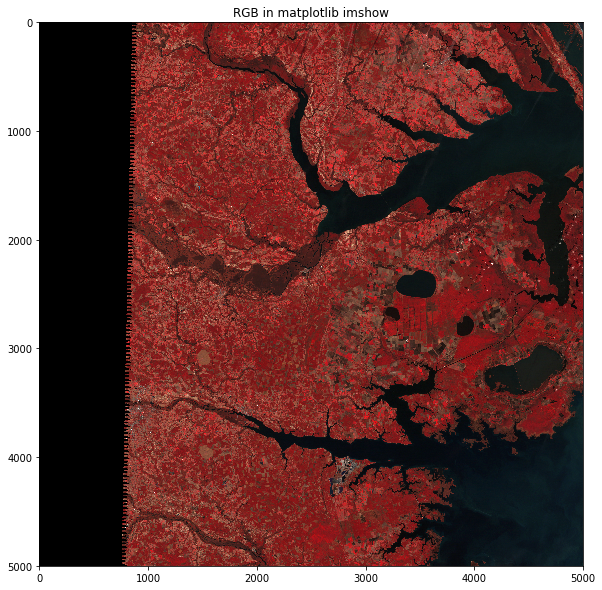

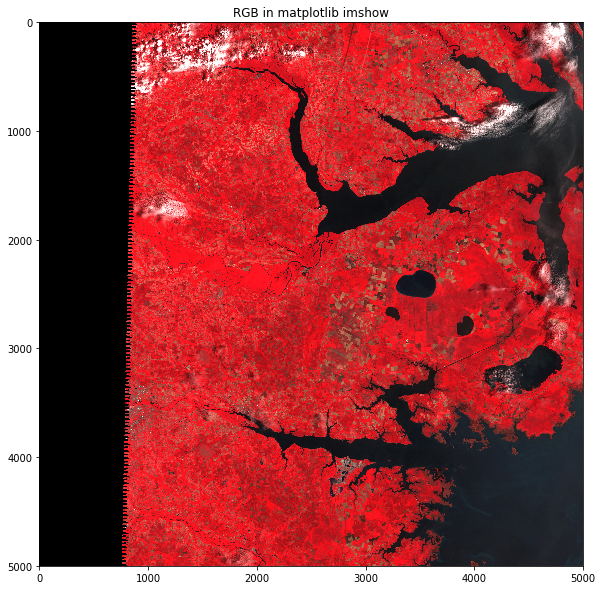

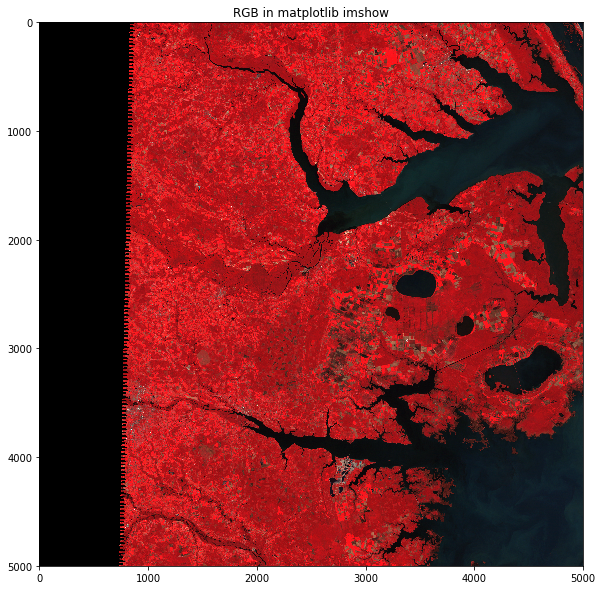

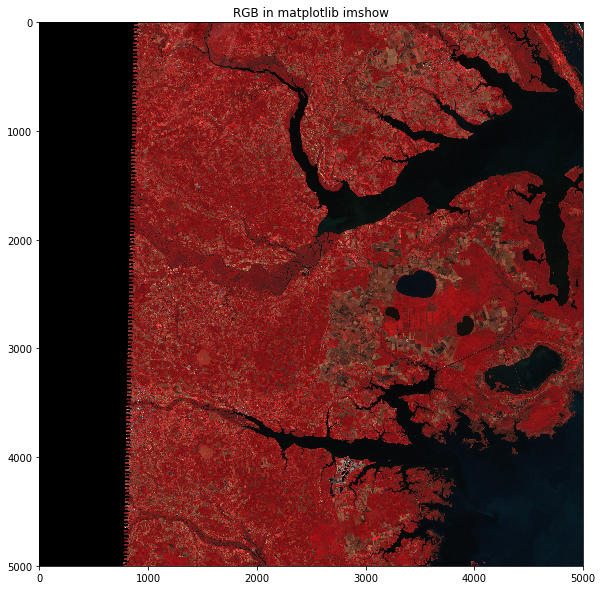

In [27]:
view_landsat(landsat_datasets['028011'][0])
view_landsat(landsat_datasets['028011'][1])
view_landsat(landsat_datasets['028011'][2])
view_landsat(landsat_datasets['028011'][3])